<a href="https://colab.research.google.com/github/gangakailas/DeepLearning/blob/main/DimensionalityReduction_and_RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


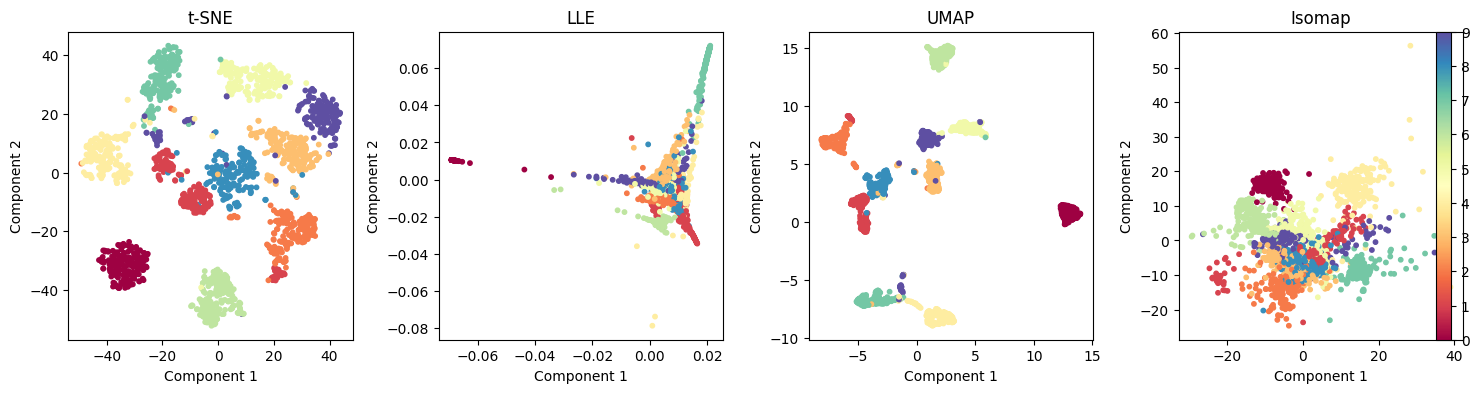

In [3]:
# --- Imports ---
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
import umap

# --- Load and standardize high-dimensional dataset ---
digits = load_digits()
X = StandardScaler().fit_transform(digits.data)
y = digits.target

# --- 1️⃣ t-SNE ---
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X)

# --- 2️⃣ Locally Linear Embedding (LLE) ---
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=0)
X_lle = lle.fit_transform(X)

# --- 3️⃣ UMAP ---
umap_model = umap.UMAP(n_components=2, n_neighbors=10, random_state=0)
X_umap = umap_model.fit_transform(X)

# --- 4️⃣ Isomap ---
isomap = Isomap(n_components=2, n_neighbors=10)
X_isomap = isomap.fit_transform(X)

import warnings
warnings.filterwarnings("ignore")
# --- Plot all embeddings side by side ---
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
methods = ['t-SNE', 'LLE', 'UMAP', 'Isomap']
embeddings = [X_tsne, X_lle, X_umap, X_isomap]

for ax, X_emb, title in zip(axs, embeddings, methods):
    sc = ax.scatter(X_emb[:, 0], X_emb[:, 1], c=y, cmap='Spectral', s=10)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

plt.colorbar(sc, ax=axs, fraction=0.02)
plt.subplots_adjust(wspace=0.3)  # ✅ avoids tight_layout warning
plt.show()



100%|██████████| 9.91M/9.91M [00:00<00:00, 87.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 45.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 24.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.00MB/s]


Epoch 1/5, Reconstruction Error: 0.1146
Epoch 2/5, Reconstruction Error: 0.0838
Epoch 3/5, Reconstruction Error: 0.0768
Epoch 4/5, Reconstruction Error: 0.0731
Epoch 5/5, Reconstruction Error: 0.0706


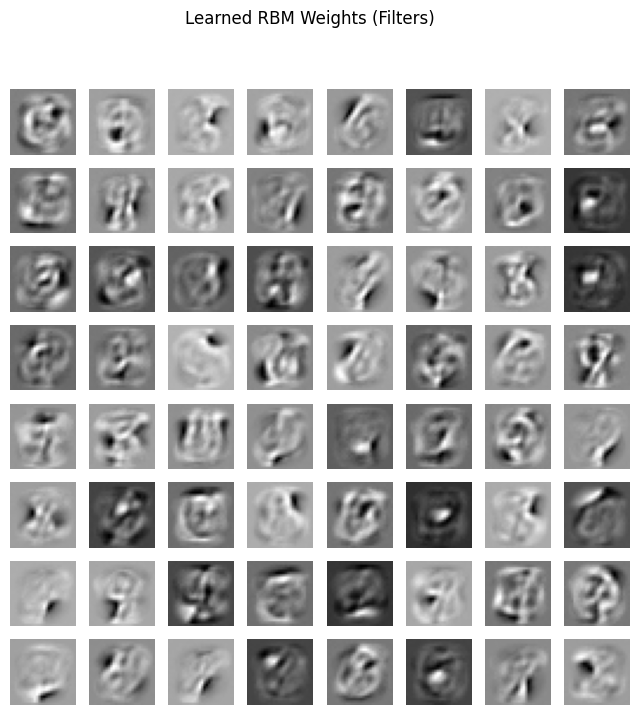

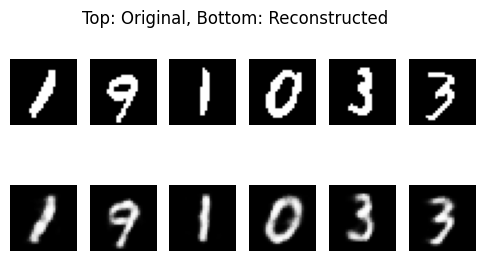

Observation: The reconstruction error decreases over epochs (final error=0.0706), showing that the RBM learns to represent the input data more accurately as training progresses.


In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Binarized MNIST (0/1) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# --- RBM Class ---
class RBM(nn.Module):
    def __init__(self, n_vis=784, n_hid=64):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))

    def sample_h(self, v):
        prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return prob, torch.bernoulli(prob)

    def sample_v(self, h):
        prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return prob, torch.bernoulli(prob)

    def forward(self, v):
        h_prob, h_sample = self.sample_h(v)
        v_prob, v_sample = self.sample_v(h_prob)
        return v_prob, h_prob

import torch.nn.functional as F

# --- Training Function ---
def train_rbm(rbm, data_loader, lr=0.1, k=1, epochs=5):
    reconstruction_errors = []
    for epoch in range(epochs):
        epoch_err = 0
        for batch, _ in data_loader:
            v0 = batch.view(-1, 784).to(device)
            # Positive phase
            h_prob, h_sample = rbm.sample_h(v0)
            # Gibbs Sampling k-step
            vk = v0.clone()
            for _ in range(k):
                h_prob_k, h_sample_k = rbm.sample_h(vk)
                v_prob_k, vk = rbm.sample_v(h_prob_k)
            # Negative phase
            h_prob_k, _ = rbm.sample_h(vk)
            # Weight update (CD-1)
            rbm.W.data += lr * (torch.matmul(h_prob.t(), v0) - torch.matmul(h_prob_k.t(), vk)) / v0.size(0)
            rbm.v_bias.data += lr * torch.mean(v0 - vk, dim=0)
            rbm.h_bias.data += lr * torch.mean(h_prob - h_prob_k, dim=0)
            epoch_err += torch.mean((v0 - vk) ** 2).item()
        reconstruction_errors.append(epoch_err / len(data_loader))
        print(f"Epoch {epoch+1}/{epochs}, Reconstruction Error: {reconstruction_errors[-1]:.4f}")
    return reconstruction_errors

# --- Initialize RBM ---
rbm = RBM(n_vis=784, n_hid=64).to(device)
errors = train_rbm(rbm, train_loader, lr=0.1, k=1, epochs=5)

# --- Visualize learned weights (filters) ---
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(rbm.W[i].detach().cpu().view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Learned RBM Weights (Filters)")
plt.show()

# --- Reconstruct some inputs ---
data_iter = iter(train_loader)
images, _ = next(data_iter)
v = images.view(-1, 784).to(device)
v_prob, h_prob = rbm.forward(v)
reconstructed = v_prob.view(-1, 1, 28, 28).detach().cpu()

# Original vs Reconstructed
plt.figure(figsize=(6, 3))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(v[i].cpu().view(28, 28), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 6, i+7)
    plt.imshow(reconstructed[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Top: Original, Bottom: Reconstructed")
plt.show()

# --- Single-sentence conclusion about reconstruction error ---
print(f"Observation: The reconstruction error decreases over epochs (final error={errors[-1]:.4f}), "
      "showing that the RBM learns to represent the input data more accurately as training progresses.")
